In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from nixtla import NixtlaClient
import math
pd.options.mode.chained_assignment = None  
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-aCYd8dJ44XStxX5iyAxWmaBivQ1ustAC8dpj1C4ZEPI8wM1VuQ9KDyoCIibC3oX6XaUG4Q5Q9l1jQ7io')
from toolz.functoolz import pipe
from toolz import curry
import random
import numpy as np
import fn
from sklearn.preprocessing import MinMaxScaler

pd.options.display.width = 180

Getting started at https://docs.nixtla.io/docs/getting-started-about_timegpt

In [8]:
# scaler = MinMaxScaler(feature_range=(0, 1))

# @curry
# def rescale (col, df):
#   df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
#   return df

dp = pipe(
  fn.readFile("./data/TripleWitching-2024-05-06 15_56_54.csv")
  ,lambda df: df.rename(columns={'NASDAQ_Canadian_Chix_A': 'y'})
  ,fn.rescale("y")
  ,fn.addDateTime
  ,fn.keep(["ds","y"])
  ,fn.addExogenous("y")
  ,lambda df: df.fillna(0)
  #,fn.logTransform("y")
)

(dpa,dpx) = pipe(dp
  ,fn.splitByDate("2024-04-15 00:00:00")
  ,fn.dropSeriesFromTestData("y")
)

print("dpa:")
print(dpa.head(8))
print("dpx:")
print(dpx.head(8))

TypeError: 'curry' object is not subscriptable

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Using the following exogenous variables: marketOpen
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


                    ds   TimeGPT  TimeGPT-lo-90  TimeGPT-lo-80  TimeGPT-hi-80  TimeGPT-hi-90
0  2024-04-15 01:00:00  0.007011      -0.008308      -0.003230       0.017253       0.022330
1  2024-04-15 02:00:00  0.002297      -0.006427      -0.005786       0.010381       0.011022
2  2024-04-15 03:00:00  0.012532       0.000819       0.004656       0.020408       0.024246
3  2024-04-15 04:00:00 -0.003903      -0.014341      -0.011561       0.003756       0.006535
4  2024-04-15 05:00:00  0.001452      -0.010873      -0.009183       0.012087       0.013777


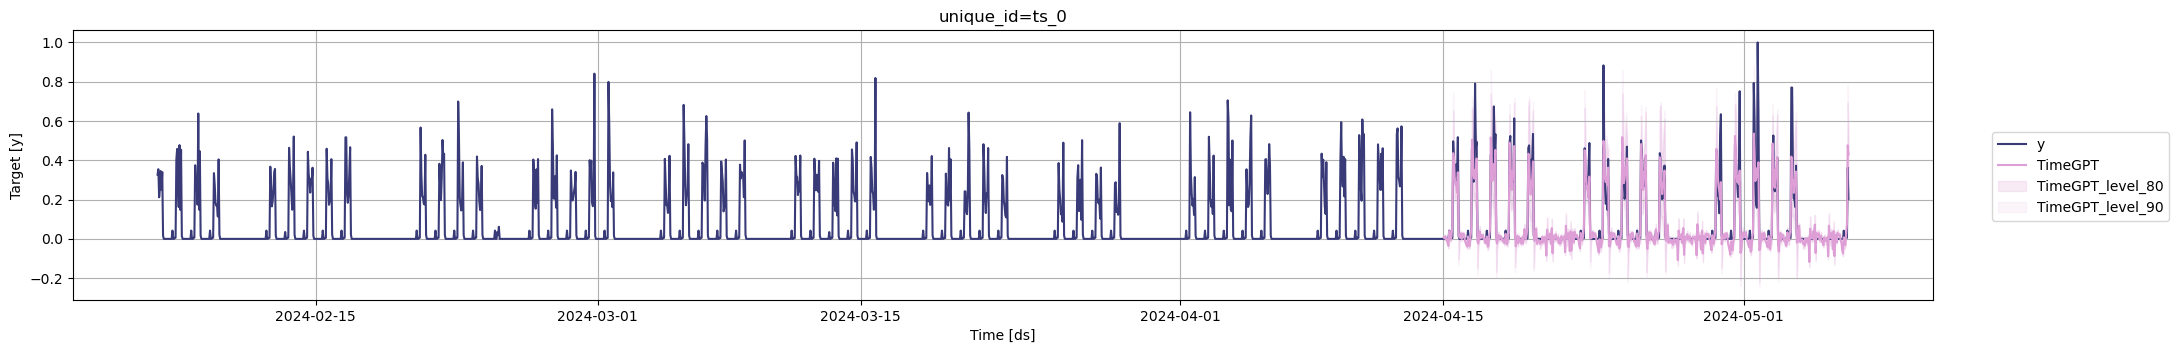

In [ ]:
fcst_df = pipe((dpa,dpx)
  ,lambda dp: nixtla_client.forecast(
    dp[0]
    ,X_df=dp[1]
    ,h=dpx.shape[0]    # number of rows in dpx
    ,model='timegpt-1-long-horizon'
    #,time_col="ds"
    #,target_col="NASDAQ_Canadian_Chix_A"
    ,level=[80,90]
    ,finetune_steps=30
    #,finetune_loss='mae', 
  )
  ,lambda df: print(df.head()) or df
  #,fn.expTransform
)

nixtla_client.plot(dp, fcst_df, level=[80,90]) 

<Axes: ylabel='features'>

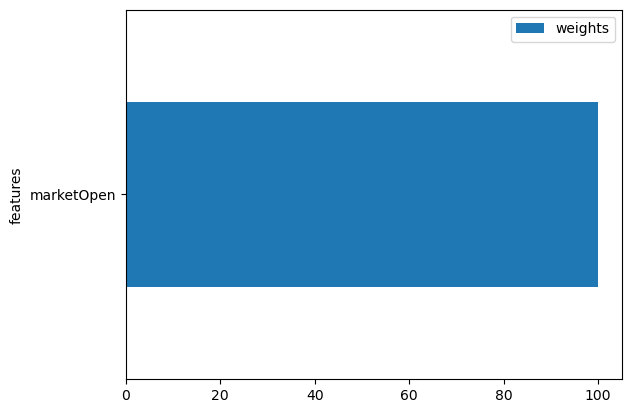

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: marketOpen


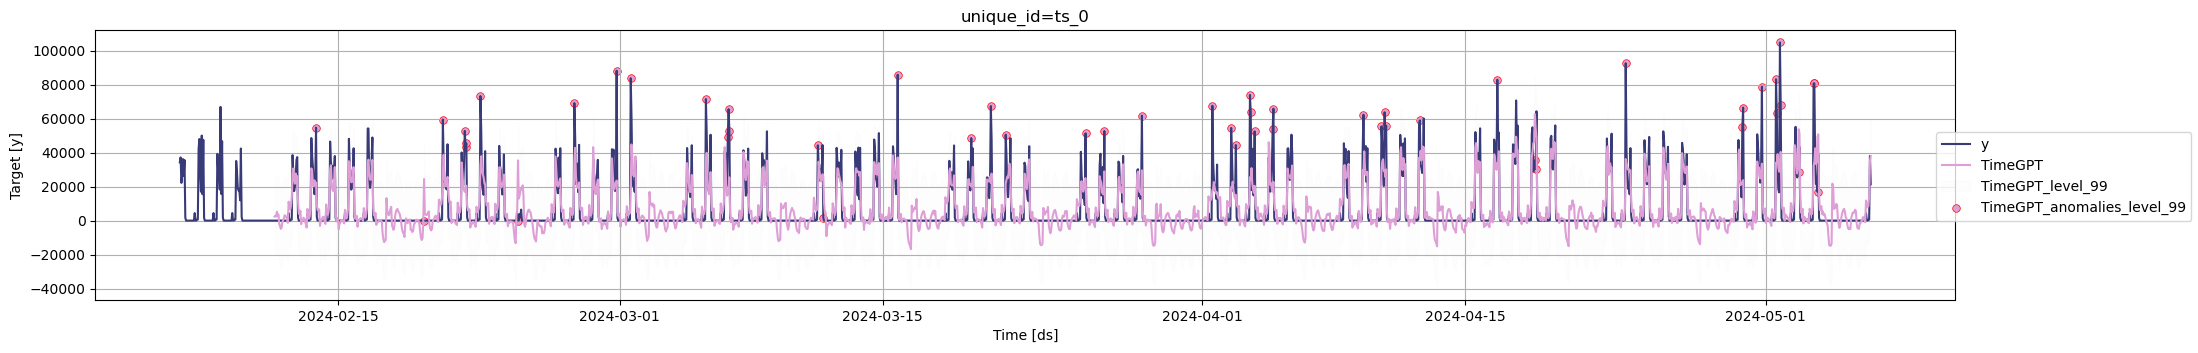

In [ ]:
anomalies_df = nixtla_client.detect_anomalies(dp, freq='h')   # time_col='ds', target_col='y',
nixtla_client.plot(dp, anomalies_df)                          # ,time_col='ds', target_col='y'